# Supervised Model Training Without Feature Engineering 


In [1]:
# import libraries
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Data Preprocessing for Model Training and Evaluation

In [2]:
# Read the dataset
df = pd.read_csv("final_dataset.csv")

# Preprocess text data
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # removing non-word characters
    text = re.sub(r'\W', ' ', str(text))
    # converting letters to lowercase
    text = text.lower()
    # lemmatizing and filtering stop words 
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

# Apply text preprocessing
df['REVIEW_TEXT'] = df['REVIEW_TEXT'].apply(preprocess_text)

# Split the data
X = df.drop('LABEL', axis=1)
y = df['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define lists of feature types for preprocessing steps
numeric_features = ['RATING']
# Numeric preprocessing: Impute missing values with median and scale data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handles missing values
    ('scaler', StandardScaler())                    # Standardizes numeric features
])

# Text feature for transformation
text_features = 'REVIEW_TEXT'
# Text preprocessing: Convert text to a numerical representation
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())  # Converts text to TF-IDF coefficients
])

# Categorical features to be one-hot encoded
categorical_features = [col for col in X.columns if col not in numeric_features + [text_features]]
# Categorical preprocessing: Impute missing values and apply one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fills missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Converts categorical data to one-hot vectors
])

# Combine all preprocessing steps into a single transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),  # Apply numeric transformer to numeric features
    ('cat', categorical_transformer, categorical_features),  # Apply categorical transformer
    ('text', text_transformer, text_features)  # Apply text transformer
])

### Hyperparameter Tuning and Model Development

In [3]:
# Define the scorer
scorer = make_scorer(accuracy_score)

# Models and their hyperparameter grids
model_params = {
    'KNN': (KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5, 7]}),
    'SVM': (SVC(random_state=42, probability=True), {'classifier__C': [0.1, 1], 'classifier__kernel': ['rbf', 'linear']}),
    'RF': (RandomForestClassifier(random_state=42), {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [None, 10]}),
    'LR': (LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs'), {'classifier__C': [0.01, 0.1, 1]})
}

# Iterating over models and their parameter grids for tuning
best_models = {}
best_scores = {}

for name, (model, params) in model_params.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Apply GridSearchCV with 5-fold cross-validation 
    grid_search = GridSearchCV(pipeline, params, cv=5, scoring=scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    
    print(f"{name} Best Score: {best_scores[name]:.4f}")
    print(f"{name} Best Parameters: {grid_search.best_params_}")

# Summarizing the best model across all
best_model_name = max(best_scores, key=best_scores.get)
print(f"Overall Best Model: {best_model_name} with CV Accuracy: {best_scores[best_model_name]:.4f}")

KNN Best Score: 0.7304
KNN Best Parameters: {'classifier__n_neighbors': 7}
SVM Best Score: 0.7786
SVM Best Parameters: {'classifier__C': 1, 'classifier__kernel': 'linear'}
RF Best Score: 0.7938
RF Best Parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
LR Best Score: 0.7878
LR Best Parameters: {'classifier__C': 1}
Overall Best Model: RF with CV Accuracy: 0.7938


###  Performance Evaluation

KNN - Accuracy: 0.7676, Precision: 0.7710, Recall: 0.7676, F1 Score: 0.7661
KNN Confusion Matrix:


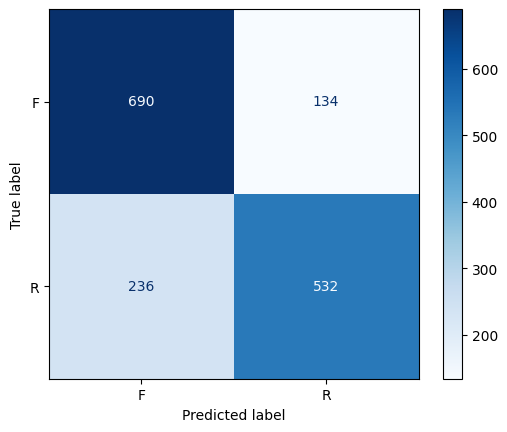

SVM - Accuracy: 0.7971, Precision: 0.7973, Recall: 0.7971, F1 Score: 0.7972
SVM Confusion Matrix:


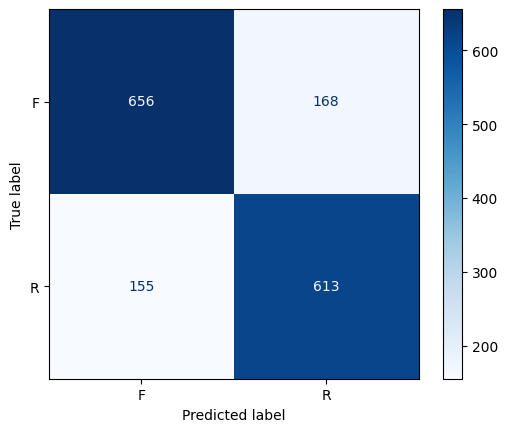

RF - Accuracy: 0.8191, Precision: 0.8191, Recall: 0.8191, F1 Score: 0.8190
RF Confusion Matrix:


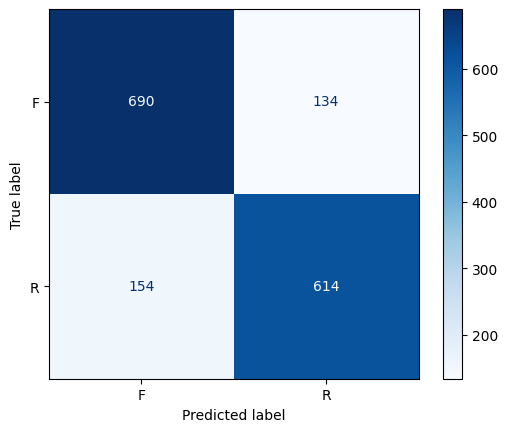

LR - Accuracy: 0.8134, Precision: 0.8142, Recall: 0.8134, F1 Score: 0.8135
LR Confusion Matrix:


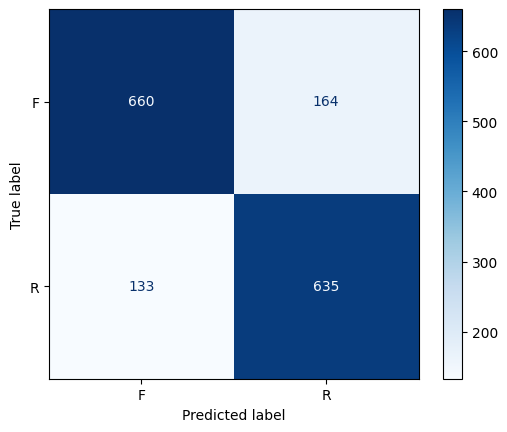

Best Model by F1 Score: RF with F1 Score: 0.8190


In [4]:
# Initialize a dictionary to store metrics
model_metrics = {}

for name, best_model_pipeline in best_models.items():
    # Make predictions on the test set using the best estimator
    y_pred = best_model_pipeline.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)  

    # Store metrics and the confusion matrix
    model_metrics[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm  # Storing the confusion matrix
    }

# Print all metrics and display confusion matrices
for model, metrics in model_metrics.items():
    print(f"{model} - Accuracy: {metrics['Accuracy']:.4f}, Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, F1 Score: {metrics['F1 Score']:.4f}")

    # Display the confusion matrix
    cm = metrics['Confusion Matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_models[model].classes_)
    print(f"{model} Confusion Matrix:")
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Optionally, to find the best model based on a specific metric
best_by_f1 = max(model_metrics, key=lambda x: model_metrics[x]['F1 Score'])
print(f"Best Model by F1 Score: {best_by_f1} with F1 Score: {model_metrics[best_by_f1]['F1 Score']:.4f}")